In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0,'/home/bradhakrishnan/ECE276A_PR1/code/')

In [3]:
import load_data
import os
# load_data.read_data()
data_base_path= "/home/bradhakrishnan/ECE276A_PR1/data/"
 

# CALIBRATION Tasks 

1. Figure out how long the setup is static to measure the bias.
2. Once bias computed use the Value formula to find the values.
3. DONT FORGET TO CONVERT THE UNITS.

In [4]:
import jax
import jax.numpy as jnp
import numpy as np
imud, vicd, camd=load_data.load_dataset(3)
# vicd_data = jnp.array(vicd['rots'])
# vicd_ts = jnp.array(vicd['ts'], dtype=np.float64)
vicd_data=vicd['rots']
vicd_ts=vicd['ts']

Data import took: 0.009355783462524414 sec.



In [5]:
def if_rotation_identity(rotation, threshold=0.001, debug=False):
    diagonal = jnp.diag(rotation)
    if debug:
        print(jnp.abs(diagonal - 1.0))
    is_diagonal_close_to_one = jnp.all(jnp.abs(diagonal - 1.0) < threshold)
    if debug:
        print(is_diagonal_close_to_one)
    return is_diagonal_close_to_one

def find_stationary_end(vicd_data, threshold=0.001, debug=False):
    idx=0
    while(if_rotation_identity(vicd_data[:,:, idx], threshold, debug=debug)):
        idx+=1
    if debug:
        print(idx)
    return idx


def get_static_data(vicd_data, vicd_ts, imu_data, indentity_check_threshold=0.001, debug=False):
    stationary_end_idx= find_stationary_end(vicd_data, threshold=indentity_check_threshold, debug=debug)
    print("Number of Static entries:: ", stationary_end_idx)
    stationary_start_time= vicd_ts[:,0][0]  
    stationary_end_time= vicd_ts[:,stationary_end_idx][0]
    static_imu_data=imu_data[:,0:stationary_end_idx]
    if stationary_start_time== static_imu_data[0, 0] and stationary_end_time==static_imu_data[0,stationary_end_idx-1]:
        print(f"We might have to match the timestamps :: \nVidcon start:: {stationary_start_time} \nIMU start:: {static_imu_data[0, 0]}" )
        print(f"\n\nVidcon end:: {stationary_end_time} \nIMU end:: {static_imu_data[0, stationary_end_idx-1]}" )
        print(stationary_start_time-static_imu_data[0, 0])
        print(stationary_end_time-static_imu_data[0, stationary_end_idx-1])
    return static_imu_data

In [6]:
all_static_data= None
for ii in range(1,10):
    print(f"Dataset {ii} :: \n")
    imud, vicd, camd=load_data.load_dataset(ii)
    vicd_data = vicd['rots']
    vicd_ts = vicd['ts']
    imu_data= imud
    static_imu_data= get_static_data(vicd_data, vicd_ts, imu_data, indentity_check_threshold=0.01, debug=False)
    if all_static_data is None:
        all_static_data=static_imu_data
    else:
        all_static_data= np.concatenate((all_static_data, static_imu_data), axis=1)

bias= np.mean(all_static_data[1:, :], axis=1)
# we need to manually compute the bias for 
print(f"Bias ::",bias)


Dataset 1 :: 

Data import took: 0.016249895095825195 sec.

Number of Static entries::  1082
Dataset 2 :: 

Data import took: 0.008254766464233398 sec.

Number of Static entries::  902
Dataset 3 :: 

Data import took: 0.0026216506958007812 sec.

Number of Static entries::  618
Dataset 4 :: 

Data import took: 0.012856483459472656 sec.

Number of Static entries::  697
Dataset 5 :: 

Data import took: 0.0030257701873779297 sec.

Number of Static entries::  503
Dataset 6 :: 

Data import took: 0.0078067779541015625 sec.

Number of Static entries::  430
Dataset 7 :: 

Data import took: 0.005032777786254883 sec.

Number of Static entries::  495
Dataset 8 :: 

Data import took: 0.003371715545654297 sec.

Number of Static entries::  748
Dataset 9 :: 

Data import took: 0.010157108306884766 sec.

Number of Static entries::  637
Bias :: [-511.0872055  -500.94437173  606.54433901  374.07738874  375.6809555
  370.13007199]


In [7]:

## SENSITIVITY 
accl_sensitivity_all_axis=300 #mV/g
yaw_sensitivity = 3.33*(180/jnp.pi) #mV/ °/s
roll_sensitivity = 3.33*(180/jnp.pi)
pitch_sensitivity = 3.33*(180/jnp.pi)

## REFERENCE VOLTAGES
accl_vref= 3.3*1000
yaw_vref= 3.3*1000 #z axis
roll_vref=3.3*1000 # x axis
pitch_vref=3.3*1000 # y axis

In [32]:
# in the bias list the value we get z axis linear acceleration is basically the measurement for 9.8 m/s( i.e; g) acceleration
# so we can mathematically compute the bias using the avg(IMU measurement for 1g)-(1/scale_factor)

# acc_z_bias= bias[2]- (1/((accl_vref/1023)/accl_sensitivity_all_axis))
# bias= bias.at[2].set(acc_z_bias)
# acc_x= (all_static_data[1,:]- bias[0]) * ((accl_vref/1023)/accl_sensitivity_all_axis)
# acc_y= (all_static_data[2,:]- bias[1]) * ((accl_vref/1023)/accl_sensitivity_all_axis)
# acc_z= (all_static_data[3,:]- bias[2]) * ((accl_vref/1023)/accl_sensitivity_all_axis)

# w_x= (all_static_data[4,:]- bias[3]) * ((roll_vref/1023)/roll_sensitivity)
# w_y= (all_static_data[5,:]- bias[4]) * ((pitch_vref/1023)/pitch_sensitivity)
# w_z= (all_static_data[6,:]- bias[5]) * ((yaw_vref/1023)/yaw_sensitivity)

(514.0, Array(142.79596, dtype=float32))

In [8]:
for ii in range(1,10):
    print(f"Dataset {ii} :: \n")
    imud, vicd, camd=load_data.load_dataset(ii)
    # vicd_data = jnp.array(vicd['rots'])
    # vicd_ts = jnp.array(vicd['ts'])
    # imu_data= jnp.array(imud)
    
    vicd_data = vicd['rots']
    vicd_ts = vicd['ts']
    imu_data= imud

    
    # in the bias list the value we get z axis linear acceleration is basically the measurement for 9.8 m/s( i.e; g) acceleration
    # so we can mathematically compute the bias using the avg(IMU measurement for 1g)-(1/scale_factor)
    acc_z_bias= bias[2]- 1/((accl_vref/1023)/accl_sensitivity_all_axis)
    # bias= bias.at[2].set(acc_z_bias)
    bias[2]=acc_z_bias
    acc_x= (imu_data[1,:]- bias[0]) * ((accl_vref/1023)/accl_sensitivity_all_axis)
    acc_y= (imu_data[2,:]- bias[1]) * ((accl_vref/1023)/accl_sensitivity_all_axis)
    acc_z= (imu_data[3,:]- bias[2]) * ((accl_vref/1023)/accl_sensitivity_all_axis)
    
    w_x= (imu_data[4,:]- bias[3]) * ((roll_vref/1023)/roll_sensitivity)
    w_y= (imu_data[5,:]- bias[4]) * ((pitch_vref/1023)/pitch_sensitivity)
    w_z= (imu_data[6,:]- bias[5]) * ((yaw_vref/1023)/yaw_sensitivity)

    # Preserve the 0th row from imu_data
    calibrated_imu = np.zeros_like(imu_data)
    
    # # Set the 0th row
    # calibrated_imu = calibrated_imu.at[0, :].set(imu_data[0, :])
    
    # # Set the computed acceleration and angular velocity values
    # calibrated_imu = calibrated_imu.at[1, :].set(acc_x)
    # calibrated_imu = calibrated_imu.at[2, :].set(acc_y)
    # calibrated_imu = calibrated_imu.at[3, :].set(acc_z)
    # calibrated_imu = calibrated_imu.at[4, :].set(w_x)
    # calibrated_imu = calibrated_imu.at[5, :].set(w_y)
    # calibrated_imu = calibrated_imu.at[6, :].set(w_z)

    # Set the 0th row
    calibrated_imu[0, :] = imu_data[0, :]
    
    # Set the computed acceleration and angular velocity values
    calibrated_imu[1, :] = acc_x
    calibrated_imu[2, :] = acc_y
    calibrated_imu[3, :] = acc_z
    calibrated_imu[4, :] = w_x
    calibrated_imu[5, :] = w_y
    calibrated_imu[6, :] = w_z
    break


Dataset 1 :: 

Data import took: 0.015946149826049805 sec.



# ORIENTATION Tracking

MOTION model => qt+1 = f(qt, τtωt) := qt ◦ exp([0, τtωt/2])

OBSERVATION model => [0, at] = h(qt) := (qt^-1) ◦ [0, 0, 0, −g] ◦ qt]

1. The starting point is q0 = [1, 0, 0, 0],
2. Find qt+1 = f(qt, τtωt) := qt ◦ exp([0, τtωt/2])

In [9]:
q0 =jnp.array([1, 0, 0, 0])
calibrated_imu.shape[1]


5645

In [186]:
exp_term


Array([ 0.0000000e+00, -2.2720992e-06,  9.3670060e-06, -3.3178414e-05],      dtype=float32)

In [10]:
import transforms3d as t3d
from tqdm import tqdm
prev_q=q0
pred_qts= []
for sample_idx in range(0,calibrated_imu.shape[1]-1):
    
    del_t= (imu_data[0,sample_idx+1]- imu_data[0,sample_idx])*0.5
    w_vec=jnp.array(calibrated_imu[4:,sample_idx])
    exp_term = jnp.concatenate((jnp.array([0]), w_vec*del_t), axis=0)
    curr_q= t3d.quaternions.qmult(prev_q,t3d.quaternions.qexp(exp_term))
    pred_qts.append(curr_q)
    prev_q=curr_q
    # h(qt) compute
    curr_q_inv= t3d.quaternions.qinverse(curr_q) 
    temp=t3d.quaternions.qmult(curr_q_inv, jnp.array([0,0,0,-1]))
    h_qt=t3d.quaternions.qmult(temp, curr_q)
    
pred_qts = np.column_stack(pred_qts)


In [11]:
pred_qts[:, 2000] , calibrated_imu[4:,2000]

(array([ 0.7436789 ,  0.04891841, -0.6648259 ,  0.05061839], dtype=float32),
 array([-0.03512281,  0.71549614,  0.03161523]))

In [12]:
gt_roll=[0]* vicd_data.shape[-1]
gt_pitch=[0]* vicd_data.shape[-1]
gt_yaw=[0]* vicd_data.shape[-1]
pred_roll=[0]* vicd_data.shape[-1]
pred_pitch=[0]* vicd_data.shape[-1] 
pred_yaw =[0]* vicd_data.shape[-1]


for idx in range(vicd_data.shape[-1]):    
    gt_roll[idx] , gt_pitch[idx] , gt_yaw[idx] =t3d.euler.mat2euler(vicd_data[:,:, idx], 'sxyz')
    pred_roll[idx], pred_pitch[idx], pred_yaw[idx] = t3d.euler.mat2euler(t3d.quaternions.quat2mat(pred_qts[:,idx]), 'sxyz')


In [183]:
pred_qts[:, 1]

array([ 1.0000000e+00, -3.7371843e-05,  2.0221012e-05, -4.0710249e-05],
      dtype=float32)

In [13]:
import matplotlib.pyplot as plt

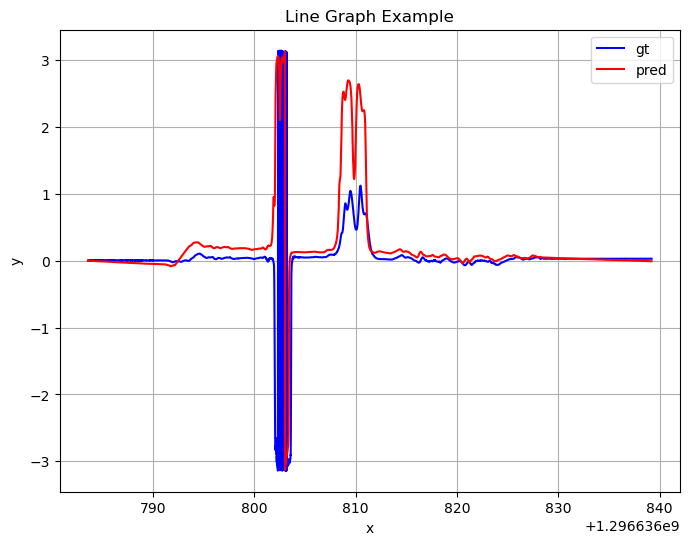

In [27]:
# Create a figure and axis
plt.figure(figsize=(8, 6))

# Plot a line graph
plt.plot(vicd_ts[0,:], gt_yaw , label='gt', color='blue')
plt.plot(vicd_ts[0,:], pred_yaw, label='pred', color='red')

# Adding title and labels
plt.title('Line Graph Example')
plt.xlabel('x')
plt.ylabel('y')

# Adding a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [23]:
gt_yaw * int(180/jnp.pi)

[0.004558270054145085,
 0.004228700289448041,
 0.004737457988627647,
 0.006485696316638073,
 0.00623752276591044,
 0.004476043559166198,
 0.004505191523189664,
 0.004626234459595258,
 0.006241854321926952,
 0.005948759185011667,
 0.006724522778449341,
 0.007605389238156035,
 0.00637967350827732,
 0.006014260864155738,
 0.00687014016360826,
 0.004694272221134846,
 0.004600567204938283,
 0.006229752475251336,
 0.0059178694417259545,
 0.004704865527673598,
 0.004702410527511395,
 0.0046553550089370975,
 0.004487002940139222,
 0.004484269840357957,
 0.004572998245790187,
 0.004569690637041254,
 0.006642010212586874,
 0.00446922375611841,
 0.0047729603488433645,
 0.007028908916165134,
 0.0062522438605132295,
 0.006552945498715912,
 0.0068696931807056385,
 0.007450957826994064,
 0.007323900926231117,
 0.006534281733509392,
 0.007056599653843756,
 0.007588961731848869,
 0.004686722417601378,
 0.004654064285099829,
 0.004709009886773099,
 0.007199640738093636,
 0.00849005280026492,
 0.00752326

In [133]:
exp_term
print(t3d.euler.mat2euler(vicd_data[:,:, 0], 'sxyz'))

print(t3d.euler.mat2euler(t3d.quaternions.quat2mat(pred_qts[:,0]), 'sxyz'))

(-0.0016304305382098825, -0.011250113844923547, 0.004558270054145085)
(-4.78473130694914e-06, 1.972529102948543e-05, -8.041903935990648e-06)


In [84]:
t3d.euler.mat2euler(vicd_data[:,:, 0], 'sxyz')


(-0.0016304305382098825, -0.011250113844923547, 0.004558270054145085)

In [89]:
t3d.quaternions.qnorm(t3d.quaternions.mat2quat(vicd_data[:,:, 0]))

0.9999999999999997

In [102]:
t3d.quaternions.qnorm(curr_q)

1.0

array([1.29663678e+09, 1.29663678e+09, 1.29663678e+09, ...,
       1.29663684e+09, 1.29663684e+09, 1.29663684e+09])